## 1. Setup models

In [ ]:
# !git clone https://github.com/HemaxiN/DL_ECG_Classification.git

Cloning into 'DL_ECG_Classification'...
remote: Enumerating objects: 811, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 811 (delta 162), reused 204 (delta 127), pack-reused 552 (from 1)
Receiving objects: 100% (811/811), 14.00 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (501/501), done.


In [2]:
!pip install -U -r DL_ECG_Classification/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached argon2_cffi-21.3.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached argon2_cffi_bindings-21.2.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached asttokens-2.0.5-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached attrs-21.4.0-py2.py3-none-any.whl.metadata (9.8 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl.metadata (11 kB)
  Using cached debugpy-1.6.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (1.1 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached executing-0.8.3-py2.py3-none-any.whl.metadata (8.6 kB)
  Using cached fonttools-4.31.2-py3-none-any.whl.metadata (121 kB)
  Using cached importlib_resources-5.6.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached ipykernel-6.

In [ ]:
!pip install -q tifffile pyts wfdb torchmetrics torchsummary


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


## 2. Run Dataset.ipynb
* Downloads Challenge-2021, an aggregate dataset
* & performs appropriate Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wfdb
import ast
import pickle
import os
from sklearn.model_selection import train_test_split

In [2]:
def load_raw_data(df, sampling_rate):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
path = 'challenge-2021'
sampling_rate = 100

# load and convert annotation data
Y = pd.read_csv(os.path.join(path, 'records.csv'))
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Shuffle
Y = Y.sample(frac=1).reset_index(drop=True)
X = load_raw_data(Y, sampling_rate)

# Split data into train and test
Y_train, Y_val = train_test_split(Y, test_size=0.2)
Y_dev, Y_test = train_test_split(Y_val, test_size=0.5)

# Load raw signal data
X_train = load_raw_data(Y_train, sampling_rate)
y_train = Y_train.scp_codes
print(f'Train records: {len(y_train)}')

X_dev = load_raw_data(Y_dev, sampling_rate)
y_dev = Y_dev.scp_codes
print(f'Val records: {len(y_dev)}')

X_test = load_raw_data(Y_test, sampling_rate)
y_test = Y_test.scp_codes
print(f'Val records: {len(y_test)}')

Train records: 34530
Val records: 4316
Val records: 4317


In [4]:
# Flatten lists
y_train_flat = pd.Series([', '.join(sublist) for sublist in y_train])
y_dev_flat = pd.Series([', '.join(sublist) for sublist in y_dev])
y_test_flat = pd.Series([', '.join(sublist) for sublist in y_test])

# Get value counts
train_counts = y_train_flat.value_counts()
dev_counts = y_dev_flat.value_counts()
test_counts = y_test_flat.value_counts()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'y_train': train_counts,
    'y_dev': dev_counts,
    'y_test': test_counts
})

summary_df = summary_df.fillna(0)
summary_df.sort_values(by='y_train', ascending=False)

,y_train,y_dev,y_test
NORM,15957,2047.0,1996.0
AFLT,5832,717.0,728.0
RBBB,3812,451.0,478.0
AFIB,3517,442.0,423.0
1dAVB,2507,314.0,308.0
LBBB,919,99.0,126.0
"AFLT, RBBB",690,63.0,65.0
"AFIB, RBBB",497,68.0,70.0
"1dAVB, RBBB",263,32.0,44.0
"1dAVB, LBBB",167,23.0,17.0


In [5]:
!rm -r Images
!rm -r Processed

In [6]:
preprocessed_dir = 'Processed'
os.makedirs(preprocessed_dir, exist_ok=True)

pickle_out = open(os.path.join(preprocessed_dir, "X.pickle"),"wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y.pickle"),"wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_train.pickle"),"wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_train.pickle"),"wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_dev.pickle"),"wb")
pickle.dump(X_dev, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_dev.pickle"),"wb")
pickle.dump(y_dev, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_test.pickle"),"wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test.pickle"),"wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [7]:
def labelstovector(X, y):
    '''
    Convert the labels in y into vectors:
    Multi-label problem:
    NORM: [0,0,0,0,0]
    AFIB: [1,0,0,0,0]
    AFLT: [0,1,0,0,0]
    1dAVb: [0,0,1,0,0]
    RBBB: [0,0,0,1,0]
    LBBB: [0,0,0,0,1]
    Combination example:
    AFLT and LBBB: [0,1,0,0,1]
    LBBB and RBBB and 1dAVB: [0,0,1,1,1]
    -----------------------------------------------------------
    Args: X (number of examples, signal length, number of leads)
        y (number of examples, )
    '''
    y_list = []
    X_list = []
    for label, ecg in zip(y, X):
        aux_vec = np.zeros(5)
        if 'AFIB' in label:
            aux_vec[0] = 1
        if 'AFLT' in label:
            aux_vec[1] = 1
        if '1dAVB' in label:
            aux_vec[2] = 1
        if 'RBBB' in label:
            aux_vec[3] = 1
        if 'LBBB' in label:
            aux_vec[4] = 1

        y_list.append(aux_vec)
        X_list.append(ecg)

    return X_list, y_list

In [8]:
X_train_processed, y_train_processed = labelstovector(X_train, y_train)
X_dev_processed, y_dev_processed = labelstovector(X_dev, y_dev)
X_test_processed, y_test_processed = labelstovector(X_test, y_test)

pickle_out = open(os.path.join(preprocessed_dir, "X_train_processed.pickle"),"wb")
pickle.dump(X_train_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_train_processed.pickle"),"wb")
pickle.dump(y_train_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_dev_processed.pickle"),"wb")
pickle.dump(X_dev_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_dev_processed.pickle"),"wb")
pickle.dump(y_dev_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_test_processed.pickle"),"wb")
pickle.dump(X_test_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test_processed.pickle"),"wb")
pickle.dump(y_test_processed, pickle_out)
pickle_out.close()

print('Train size:', X_train.shape)
print('Val size:', X_dev.shape)
print('Test size:', X_test.shape)

Train size: (34530, 1000, 12)
Val size: (4316, 1000, 12)
Test size: (4317, 1000, 12)


In [9]:
# Prepare 2D dataset
!mkdir -p Images/dev/labels
!mkdir -p Images/dev/images
!mkdir -p Images/train/labels
!mkdir -p Images/train/images
!mkdir -p Images/test/labels
!mkdir -p Images/test/images

# Save processed dataset at
!mkdir -p Processed/model_specific/X_rnn_train
!mkdir -p Processed/model_specific/X_rnn_dev
!mkdir -p Processed/model_specific/X_rnn_test
!mkdir -p Processed/model_specific/X_cnn_train
!mkdir -p Processed/model_specific/X_cnn_dev
!mkdir -p Processed/model_specific/X_cnn_test
!mkdir -p Processed/model_specific/labels_train
!mkdir -p Processed/model_specific/labels_dev
!mkdir -p Processed/model_specific/labels_test

# Modify `create_dataset.py` appropriately to
# specify dataset path and save directory path
!python DL_ECG_Classification/Dataset/create_dataset.py

Processed Processed/model_specific


Model output (5,)
[0. 0. 0. 0. 0.]

1D input: (1000, 12)
[[-1.42288862 -1.47504834  0.80085486 ...  0.06290159 -0.61584806
  -1.28034799]
 [-2.73500249 -3.2580864   0.62576899 ...  0.5482206  -0.72209088
  -1.39787136]
 [-2.17748866 -2.70399278  0.26470721 ...  0.57134591 -0.41723553
  -0.73992064]
 ...
 [-0.98421055 -0.98073281  0.62838778 ... -0.74637617 -0.7433812
  -0.62757443]
 [-0.8644782  -0.93524492  0.38294968 ... -0.67328029 -0.70092678
  -0.59953767]
 [-0.64015558 -0.78533262  0.09117195 ... -0.66615754 -0.6069485
  -0.53501577]]

2D input: (256, 256)


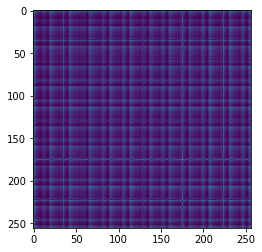

In [31]:
# View label
label = np.load('Processed/model_specific/labels_dev/0.npy')
print('Model output', label.shape)
print(label)

# View RNN input
rnn_input = np.load('Processed/model_specific/X_rnn_dev/0.npy')
print('\n1D input:', rnn_input.shape)
print(rnn_input)

# View CNN input
img = plt.imread('Processed/model_specific/X_cnn_dev/0.tif')
print('\n2D input:', img.shape)
plt.imshow(img)
plt.show()

## 3. Training

In [10]:
%cd DL_ECG_Classification

/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification


### 3.1 1D models

In [11]:
import subprocess
import time

def timed_shell(cmd):
    start = time.time()
    subprocess.run(cmd, shell=True)
    end = time.time()
    print(f'⏱️ Time taken: {end - start:.2f} seconds')

In [21]:
## RNN
# timed_shell("python3 rnn.py -data '../Processed/model_specific/' -epochs 10 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")
# timed_shell("python3 rnn.py -data '../Processed/model_specific/' -epochs 10 -batch_size 512 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01 -num_layers 2")
!python3 rnn.py -data '../Processed/model_specific/' -epochs 10 -batch_size 512 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01 -num_layers 2

Loading data...
Training epoch 1
Training loss: 0.9292
Valid specificity: 0.1940
Valid sensitivity: 0.8005 

Training epoch 2
Training loss: 0.8730
Valid specificity: 0.6024
Valid sensitivity: 0.4079 

Training epoch 3
Training loss: 0.8504
Valid specificity: 0.8012
Valid sensitivity: 0.2061 

Training epoch 4
Training loss: 0.8384
Valid specificity: 0.5976
Valid sensitivity: 0.3921 

Training epoch 5
Training loss: 0.8313
Valid specificity: 0.6000
Valid sensitivity: 0.4044 

Training epoch 6
Training loss: 0.8272
Valid specificity: 0.5714
Valid sensitivity: 0.4262 

Training epoch 7
Training loss: 0.8240
Valid specificity: 0.7155
Valid sensitivity: 0.2977 

Training epoch 8
Training loss: 0.8219
Valid specificity: 0.7969
Valid sensitivity: 0.1843 

Training epoch 9
Training loss: 0.8204
Valid specificity: 0.9150
Valid sensitivity: 0.0901 

Training epoch 10
Training loss: 0.8193
Valid specificity: 0.7981
Valid sensitivity: 0.1904 

[[ 38812  24722 269498 189650]
 [     0  96046      0

In [ ]:
## LSTM
timed_shell("python3 lstm.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

Loading data...
Training epoch 1
Training loss: 1.4131
Training epoch 23
Training loss: 1.4034
eval 929 of 1003

In [23]:
## GRU
timed_shell("python3 gru.py -data '../Processed/model_specific/' -epochs 2 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.005")
# timed_shell("python3 gru_with_attention.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.05")

Loading data...
Training epoch 1
Training loss: 0.8510
Training epoch 2
Training loss: 0.6561
[[4.960e+02 3.100e+01 9.080e+02 2.882e+03]
 [8.120e+02 1.300e+01 5.980e+02 2.894e+03]
 [3.280e+02 4.400e+01 3.240e+02 3.621e+03]
 [6.300e+02 3.200e+01 2.150e+02 3.440e+03]
 [1.950e+02 3.000e+00 4.940e+02 3.625e+03]]
       Sensitivity  Specificity  Accuracy  Precision  F1 Score
AFIB          0.94         0.76      0.78       0.35      0.51
AFLT          0.98         0.83      0.86       0.58      0.73
1dAVb         0.88         0.92      0.91       0.50      0.64
RBBB          0.95         0.94      0.94       0.75      0.84
LBBB          0.98         0.88      0.88       0.28      0.44
Mean          0.95         0.87      0.88       0.49      0.63
⏱️ Time taken: 141.71 seconds


### 3.2 2D models

In [ ]:
## AlexNet
timed_shell("python3 AlexNet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

In [ ]:
## VGGNet
timed_shell("python3 vggnet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

In [ ]:
## ResNet
timed_shell("python3 resnet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

In [ ]:
## CNN
timed_shell("python3 cnn.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")
timed_shell("python cnn_gru.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")
timed_shell("python cnn_lstm.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

### 3.3 Fusion approaches

Fusion uses 1D and 2D models so let's shift it's best models to new folder Models.

In [ ]:
%%bash
#!/bin/bash

# Define the source and destination directories
src_dir="saved_models"
dest_dir="Models"

# Create an associative array to store the largest file for each unique name
declare -A largest_files

# Loop through all files matching the pattern
for file in "$src_dir"/*_ep_*; do
  # Extract the base name (excluding ep_{n})
  base_name=$(basename "$file" | sed 's/_ep_[0-9]*//')
  
  # Check if this base name already has a file stored
  if [[ -z "${largest_files[$base_name]}" ]]; then
    largest_files[$base_name]="$file"
  else
    # Compare the current file with the stored file to find the one with the largest 'n'
    current_n=$(basename "$file" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    stored_n=$(basename "${largest_files[$base_name]}" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    
    if (( current_n > stored_n )); then
      largest_files[$base_name]="$file"
    fi
  fi
done

# Copy the largest files to the new location and rename them
for base_name in "${!largest_files[@]}"; do
  cp "${largest_files[$base_name]}" "$dest_dir/$base_name"
done

In [ ]:
timed_shell("python early_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

In [ ]:
timed_shell("python late_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

In [ ]:
timed_shell("python joint_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

## Evaluation

First, move best models to a separate directory

In [173]:
%%bash
#!/bin/bash

# Define the source and destination directories
src_dir="saved_models"
dest_dir="Models"

# Create an associative array to store the largest file for each unique name
declare -A largest_files

# Loop through all files matching the pattern
for file in "$src_dir"/*_ep_*; do
  # Extract the base name (excluding ep_{n})
  base_name=$(basename "$file" | sed 's/_ep_[0-9]*//')
  
  # Check if this base name already has a file stored
  if [[ -z "${largest_files[$base_name]}" ]]; then
    largest_files[$base_name]="$file"
  else
    # Compare the current file with the stored file to find the one with the largest 'n'
    current_n=$(basename "$file" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    stored_n=$(basename "${largest_files[$base_name]}" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    
    if (( current_n > stored_n )); then
      largest_files[$base_name]="$file"
    fi
  fi
done

# Copy the largest files to the new location and rename them
for base_name in "${!largest_files[@]}"; do
  cp "${largest_files[$base_name]}" "$dest_dir/$base_name"
done

In [26]:
!python eval_saved_models.py -gpu_id 0 \
    -model gru \
    -path saved_models/GRU_ep_2 \
    -data ../validation/Processed/model_specific/

[[0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]]

[[0. 1. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]]

[[0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0.]]

[[1. 0. 0. 0. 0.]]
[[1. 0. 1. 0. 0.]]

[[0. 0. 0. 1. 0.]]
[[0. 0. 0. 1. 0.]]

[[0. 0. 0. 0. 1.]]
[[0. 0. 1. 0. 1.]]

[[1. 0. 0. 5.]
 [0. 1. 0. 5.]
 [0. 1. 2. 3.]
 [1. 0. 0. 5.]
 [1. 0. 0. 5.]]
/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/utils.py:195: RuntimeWarning: invalid value encountered in divide
  precision   = np.where((TP + FP) > 0, TP / (TP + FP), 0)
/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/utils.py:196: RuntimeWarning: invalid value encountered in divide
  f1          = np.where((precision + sensitivity) > 0, 2 * precision * sensitivity / (precision + sensitivity), 0)
       Sensitivity  Specificity  Accuracy  Precision  F1 Score
AFIB           1.0         1.00      1.00        1.0       1.0
AFLT           0.0         1.00      0.83        0.0       0.0
1dAVb          0.0         0.60      0.50        0.0       0.0
RBBB     

array([1., 0., 0., 0.])